# Introduction to Classification Evaluation II

-----

While the standard performance metrics are useful for a standard classification task, many algorithms now generate a probabilistic classification. As a result, we need a method to not only compare different estimators, but determine the optimal threshold for an estimator. To support this decision, we introduce AUC-ROC in this lesson.

-----


## Table of Contents

[The ROC Curve and AUC](#The-ROC-Curve-and-AUC)
- [Understand ROC Curve](#Understand-ROC-Curve)
- [Plot ROC Curve](#Plot-ROC-Curve)

[Compare Models with ROC-AUC](#Compare-Models-with-ROC-AUC)

-----
Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook
%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')

-----
[[Back to TOC]](#Table-of-Contents)

## The ROC Curve and AUC

ROC stands for [receiver operating characteristic][wroc], originally developed during World War II to predict the performance of an individual using a radar system. The ROC curve displays the relationship between the false positives rate (along the x-axis) and the true positives rate(along the y-axis) as a function of probability threshold.

**True positive rate (TPR)** is the ratio of true positive over all actual positive also known as positive recall rate.
$$
TPR = \frac{True Positive}{All Actural Positive}= \frac{TP}{TP + FN}
$$

**False positive rate (FPR)** is the ratio of false positive over all actual negative:
$$
FPR = \frac{False Positive}{All Actual Negative} = \frac{FP}{TN + FP}
$$

To understand what **probability threshold** is, we can refer to the case studies in the previous lesson. In the adult income classification case studies, we set random forest classifier hyperparameter `class_weight` to achieve higher true positive(TP) in case study 1 and lower false positive(FP) in case study 2. This `class_weight` is the threshold which determines how likely the model will determine a data point as certain class. Not all classification algorithms are probability based. Among the algorithms we've learned so far, k-nearest neighbor(KNN) is not probability-based algorithm. We can't set a threshold for KNN unless we customized the algorithm. All other classification models introduced in this course, however, have `class_weight` hyperparameter as threshold.

The ROC curve is plotted with TPR(true positive rate) against the FPR(false positive rate) where TPR is on y-axis and FPR is on the x-axis.

<img src="images/roc.png" width='400'>

In above plot:
- The green curve is the ROC curve; 
- The grey area under ROC curve is the AUC or area under curve; 
- The blue right angle line is the ROC curve for a perfect model;
- The diagonal broken line is the ROC curve for random prediction.


-----

[wroc]: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

### Understand ROC Curve

To understand the ROC curve, we first plot the confusion matrix as reference.

<img src="images/confusion_matrix.png" width='500'>

We will use the case study in the previous lesson to understand the ROC curve. In the case study, we set the random forest classifier hyperparamter `class_weight` to get the desired true positive. 

Now let's assume we set `class_weight={0:1.0, 1:0.0}`. This extreme class weight setting basically tells the model to classify all data points as 0 or negative. Now both TP and FP are 0, so both TPR and FPR are also 0. This is the starting point of the ROC curve, which is the lower left corner or origin of coordinate (0, 0)

When we gradually increase positive weight, more and more data points are classified as positive. In the process, both true positives and false positives increases, as well as TPR and FPR, so the ROC curve moves up and right.

Eventually, class weight reaches to the extreme point of `class_weight={0:0.0, 1:1.0}`. The model will classify all data points as 1 or positive. Now all actual positive data points are classified as positive, thus TPR equals to 1; and all actual negative data points are also classified as positive, thus FPR also equals to 1. The ROC curve reaches to top right corner or coordinate (1, 1).

A perfect model will classify all data points correctly at a certain threshold. Let's assume the threshold is `class_weight={0:0.5, 1:0.5}`. At this threshold, all actual positives are classified as positive, thus TPR equals to 1; and all actual negatives are classified as negative, thus FPR equals to 0. When we increase weight on the positive class, TPR will remain as 1, and there will be some negative data points that are classified as positive so FPR increases along with the positive weight. Eventually when `class_weight={0:0.0, 1:1.0}`, FPR reaches to 1. This ROC curve is represented by the blue angle line in the plot, it is the ROC curve of a perfect model.

A random model, which gives random guess on output classes, "predicts" correctly 50% of the time (assuming the dataset is a balanced dataset with 50% positive and 50% negative). The ROC curve also starts from the origin. When we adjust the threshold to increase positive weight, more and more data points are classified as positive. 50% of them are predicted correctly and 50% of them are predicted wrongly. So TPR and FPR increase at the same ratio. The ROC curve for the random model is the diagonal line from origin to (1, 1), which is represented by the broken line in the plot.

The area under ROC curve is called AUC. For a perfect model, AUC is 1; for a random model, AUC is 0.5. Practically all models will have the AUC between 0.5 and 1. The larger the AUC, the better the model is. AUC can provide a useful comparison between different classification models on the same data. 



### Plot ROC Curve

To generate a ROC curve, we need to create arrays of true and false positives at different probability thresholds. The scikit-learn library provides a `roc_curve` method, which calculates TPR and FPR for range of threshold. The `roc_curve` takes true labels and probability estimates of the positive class. The probability estimates of the positive can be returned from `decision_function` method or `predict_proba` method in the model.

Among the classifiers we have learned so far, the following two use `decision_function` function to return the probability estimates of the positive class:
- Logistic Regression
- Support Vector Machine

The next three use `predict_proba` function to return the probability estimates of the positive class:
- K-nearest Neighbor
- Decision Tree
- Random Forest

The scikit-learn library also provides an `auc` method that will compute AUC from two arrays holding the true and false positive rates.

We will demonstrate an ROC curve for random forest classifier with adult income data.   
In the first cell below, we prepare data.   
In the second cell, we construct the random forest classifier, train it and get information needed to plot ROC curve. We also print out AUC of the model.  
In the third cell, we plot the ROC curve for out model, display AUC of the ROC in the label. We also plot ROC for the perfect model(right angle line) and the random model(diagonal line) in the same plot.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Read CSV data
adult_data = pd.read_csv('data/adult_income.csv')

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Encode categorical features with string value
adult_data['Sex_code'] = LabelEncoder().fit_transform(adult_data.Sex)
adult_data['Relationship_code'] = LabelEncoder().fit_transform(adult_data.Relationship)
adult_data['Race_code'] = LabelEncoder().fit_transform(adult_data.Race)

#pick training features
data = adult_data[['Age', 'HoursPerWeek', 'EducationLevel', 'CapitalGain', 'CapitalLoss', 'Sex_code', 'Relationship_code', 'Race_code']]
label = adult_data['Label']

#split to training and testing
d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

rfc = RandomForestClassifier(n_estimators=10, random_state=23)

rfc = rfc.fit(d_train, l_train)

# Grab positive class probability
y_score_rfc = rfc.predict_proba(d_test)[:, 1]

# Compute ROC curve and ROC area
fpr_rfc, tpr_rfc, thresholds = roc_curve(l_test, y_score_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
print(f'AUC of Random Forest: {roc_auc_rfc:.2f}')

AUC of Random Forest: 0.86


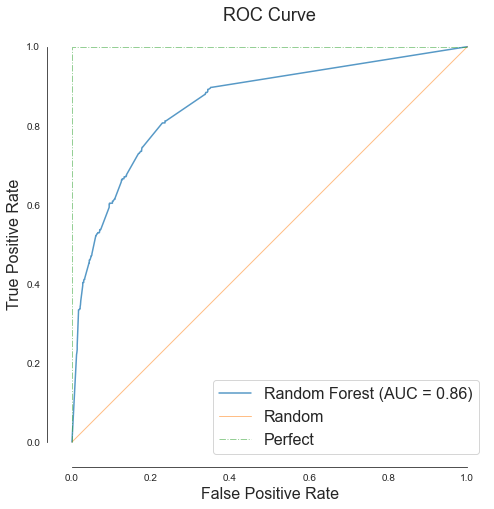

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and model
ax.plot(fpr_rfc, tpr_rfc, alpha = 0.75, linestyle='-',
        label=f'Random Forest (AUC = {roc_auc_rfc:.2f})')

#plot random and perfect model ROC
ax.plot([0, 1], [0, 1], alpha = 0.5, lw=1, linestyle='-', label='Random')
ax.plot([0, 0, 1], [0, 1, 1], alpha = 0.5, lw=1, linestyle='-.', label='Perfect')

ax.set_title('ROC Curve', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.legend(loc=4, fontsize=16)
sns.despine(offset=5, trim=True)

---
[[Back to TOC]](#Table-of-Contents)
## Compare Models with ROC-AUC

We can plot ROC for multiple models in same plot. The visualization makes it easy to compare models with ROC-AUC.

In the following code, we will construct three more models: Logistic Regression, Linear Support Vector Machine and Decision Tree. Among them, Logistic Regression and Support Vector Machine use `decision_function` , while Decision Tree uses `predict_proba` to get positive class probability.

#### Classifiers that have `decision_function`:
- Logistic Regression
- Support Vector Machine

#### Classifiers that have `predict_proba`:
- K-nearest Neighbors
- Decision Tree
- Random Forest

We will plot the ROC curve for the 3 models on top of the ROC curve of the Random Forest Classifier we created above.

In [5]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=23)
lr_model = lr_model.fit(d_train, l_train)

# Grab positive class probability
y_score_lr = lr_model.decision_function(d_test)

# Compute ROC curve and ROC area
fpr_lr, tpr_lr, thresholds = roc_curve(l_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

In [6]:
#Linear Support Vector Machine
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced', random_state=23)
svc = svc.fit(d_train, l_train)

# Grab positive class probability
y_score_svm = svc.decision_function(d_test)

# Compute ROC curve and ROC area
fpr_svm, tpr_svm, thresholds = roc_curve(l_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

In [7]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=23)
dtc = dtc.fit(d_train, l_train)

# Grab positive class probability
y_score_dtc = dtc.predict_proba(d_test)[:, 1]

# Compute ROC curve and ROC area
fpr_dt, tpr_dt, thresholds = roc_curve(l_test, y_score_dtc)
roc_auc_dt = auc(fpr_dt, tpr_dt)

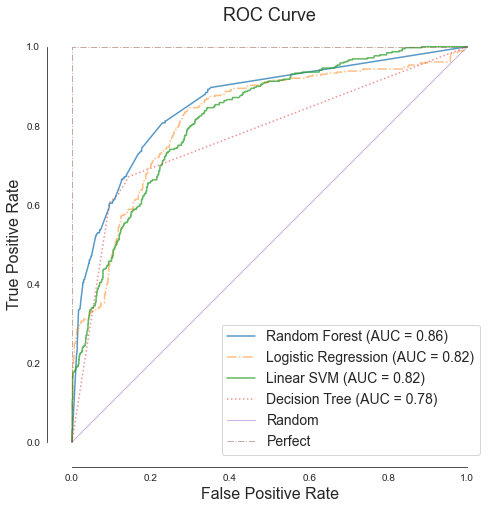

In [8]:
# Make the plots
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and model
ax.plot(fpr_rfc, tpr_rfc, alpha = 0.75, linestyle='-', 
        label=f'Random Forest (AUC = {roc_auc_rfc:.2f})')

ax.plot(fpr_lr, tpr_lr, alpha = 0.5, linestyle='-.',
        label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

ax.plot(fpr_svm, tpr_svm, alpha = 0.75, linestyle='-',
        label=f'Linear SVM (AUC = {roc_auc_svm:.2f})')

ax.plot(fpr_dt, tpr_dt, alpha = 0.5, linestyle=':',
        label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

ax.plot([0, 1], [0, 1], alpha = 0.5, lw=1, linestyle='-', label='Random')
ax.plot([0, 0, 1], [0, 1, 1], alpha = 0.5, lw=1, linestyle='-.', label='Perfect')

# Decorate plot appropriately
ax.set_title('ROC Curve', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.legend(loc=4, fontsize=14)
sns.despine(offset=5, trim=True)

-----

With the different false positive and true positive arrays corresponding to the different estimators, we have ROC curves for these four estimators, along with the random baseline and perfect classifier ROC curves. We also display the area under the curve(AUC), which provides a single metric that can be used to compare classification estimators.

When interpreting the ROC curve, the goal is to approximate as closely as possible to the perfect classifier, which reaches 100% true positive and zero false positive. On the other hand, an estimator should perform better than the baseline, which is essentially a random guess. As the figure above demonstrates, the Random Forest and Logistic Regression perform the best, followed by Linear Support Vector Machine and Decision Tree.


-----

<font color='red' size = '5'> Student Exercise </font>

In above plot, try add ROC curve for an KNN classifier. (Hint: KNN classifier uses `predict_proba` to get positive probability, just like decision tree or random forest classifier)


-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. [Understanding AUC-ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

-----


**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode